In [1]:
from typing import Annotated, Dict, List, Any
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

In [2]:
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [5]:
def router(state: State) -> str:
    last_message = state['messages'][-1].content.lower()
    if any(char in last_message for char in ['+', '-', '*', '/']):
        return 'calculator' 
    if any(char in last_message for char in ['happy', 'sad', 'angry', 'tired']):
        return 'sentiment'
    else:
        return 'fallback'

In [6]:
def calculator(state: State) -> Dict[str, Any]:
    exp = state['messages'][-1].content.lower()
    try:
        response = eval(exp)
        reply = f"The answer is {str(response)}"
    except Exception as e:
        reply = "Sorry Could not calculate that"
    return {'messages': [AIMessage(content=reply)]}

In [8]:
def sentiment(state: State) -> Dict[str, Any]:
    reply = "I'm not sure of your mood"
    sentimental_words = ['happy', 'sad', 'angry', 'tired']
    word = state['messages'][-1].content.lower()
    for mood in sentimental_words:
        if mood in word:
            reply = f"You sound {mood}!"
    return {'messages': [AIMessage(content=reply)]}

In [9]:
def fallback(state: State) -> Dict[str, Any]:
    response = "I'm sorry I do not know the answer to that question"
    return {'messages': [AIMessage(content=response)]}

In [12]:
graph = StateGraph(State)

graph.add_node('calculator_node', calculator)
graph.add_node('sentiment_node', sentiment)
graph.add_node('fallback_node', fallback)

graph.add_conditional_edges(
    START,
    router,
    {
        'calculator': 'calculator_node',
        'sentiment': 'sentiment_node',
        'fallback': 'fallback_node'
    }
)
graph.add_edge('calculator_node', END)
graph.add_edge('sentiment_node', END)
graph.add_edge('fallback_node', END)

app = graph.compile()

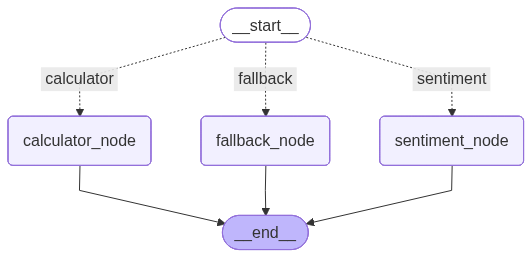

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [15]:
def test(user_input):
    state: State = {
        "messages": [HumanMessage(content=user_input)],
    }
    state = app.invoke(state)
    print("\n--- Response 1 ---")
    for m in state["messages"]:
        print(m.__class__.__name__, ":", m.content)

In [16]:
test('2+2')


--- Response 1 ---
HumanMessage : 2+2
AIMessage : The answer is 4


In [17]:
test("I'm Sad today")


--- Response 1 ---
HumanMessage : I'm Sad today
AIMessage : You sound sad!


In [18]:
test("I'm Happy today")


--- Response 1 ---
HumanMessage : I'm Happy today
AIMessage : You sound happy!


In [19]:
test('What is your name?')


--- Response 1 ---
HumanMessage : What is your name?
AIMessage : I'm sorry I do not know the answer to that question
